# 05 - Statistical Time Series Models

This notebook demonstrates statistical time series forecasting models for volume prediction. We evaluate ARIMA/SARIMA and Prophet models, comparing their performance against the baseline models from notebook 04.

## Models Covered

1. **ARIMA/SARIMA Model**: AutoRegressive Integrated Moving Average with optional seasonal components
   - Captures autoregressive dependencies and moving average effects
   - SARIMA adds seasonal patterns (weekly, yearly)
   
2. **Prophet Model**: Facebook's forecasting procedure designed for business time series
   - Automatic seasonality detection (weekly, yearly)
   - Robust to missing data and outliers
   - Interpretable components

## Evaluation Approach

- **Training**: First 365 days (captures full yearly seasonality)
- **Validation**: 7-day forecast horizon
- **Metrics**: MAE, RMSE, MAPE
- **Comparison**: Against baseline results from notebook 04

## 1. Setup and Imports

In [1]:
import sys
import warnings
from pathlib import Path
from datetime import date

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Add src to path for imports
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

# Import statistical models
from volume_forecast.models import ARIMAModel, ProphetModel

# Import evaluation metrics
from volume_forecast.evaluation import mae, rmse, mape

# Import data generator (in case we need to create data)
from volume_forecast.data_generation import VolumeGenerator

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Setup complete!")
print(f"Project root: {project_root}")

Setup complete!
Project root: C:\Users\juanlu\dev\volume-forecasting-poc


## 2. Load Data

We load the synthetic volume data generated in notebook 01. If the file does not exist, we generate it using the `VolumeGenerator`.

In [2]:
# Define data path
data_path = project_root / "data" / "raw" / "synthetic_volumes.csv"

# Load or generate data
if data_path.exists():
    df = pd.read_csv(data_path, parse_dates=["date"])
    print(f"Loaded data from {data_path}")
else:
    print(f"Data file not found at {data_path}. Generating synthetic data...")
    generator = VolumeGenerator(seed=42)
    df = generator.generate(
        start_date=date(2023, 1, 1),
        end_date=date(2024, 12, 31),
        include_events=True
    )
    # Save for future use
    data_path.parent.mkdir(parents=True, exist_ok=True)
    generator.save(df, data_path)
    print(f"Generated and saved data to {data_path}")

# Display basic info
print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total days: {len(df)}")
df.head()

Loaded data from C:\Users\juanlu\dev\volume-forecasting-poc\data\raw\synthetic_volumes.csv

Dataset shape: (731, 4)
Date range: 2023-01-01 00:00:00 to 2024-12-31 00:00:00
Total days: 731


,date,daily_logins,daily_deposits,daily_deposit_volume_gbp
0,2023-01-01,59273,9648,267406
1,2023-01-02,39425,7242,234617
2,2023-01-03,45752,6452,234713
3,2023-01-04,49327,7341,224131
4,2023-01-05,37494,7282,204090


In [3]:
# Summary statistics
df.describe()

,date,daily_logins,daily_deposits,daily_deposit_volume_gbp
count,731,731.00,731.00,731.00
mean,2024-01-01 00:00:00,53162.94,8914.91,264106.77
min,2023-01-01 00:00:00,23749.00,3085.00,122017.00
25%,2023-07-02 12:00:00,41954.50,6681.00,205804.50
50%,2024-01-01 00:00:00,48708.00,7800.00,240062.00
75%,2024-07-01 12:00:00,58406.50,9617.00,293004.50
max,2024-12-31 00:00:00,220029.00,57377.00,1029520.00
std,NaN,19731.36,4722.64,99177.18


## 3. Train/Validation Split

We split the data into training and validation sets:
- **Training**: First 365 days (captures full yearly seasonality)
- **Validation**: Remaining days (used for model evaluation)

This split respects the temporal nature of the data - we never use future data to predict the past.

In [4]:
# Sort by date to ensure chronological order
df = df.sort_values('date').reset_index(drop=True)

# Define split point
INITIAL_TRAIN_DAYS = 365
FORECAST_HORIZON = 7
TARGET = 'daily_logins'  # Primary target for forecasting

# Split data
train_df = df.iloc[:INITIAL_TRAIN_DAYS].copy()
valid_df = df.iloc[INITIAL_TRAIN_DAYS:].copy()

print(f"Training set: {len(train_df)} days ({train_df['date'].min().date()} to {train_df['date'].max().date()})")
print(f"Validation set: {len(valid_df)} days ({valid_df['date'].min().date()} to {valid_df['date'].max().date()})")
print(f"\nTarget variable: {TARGET}")
print(f"Forecast horizon: {FORECAST_HORIZON} days")

Training set: 365 days (2023-01-01 to 2023-12-31)
Validation set: 366 days (2024-01-01 to 2024-12-31)

Target variable: daily_logins
Forecast horizon: 7 days


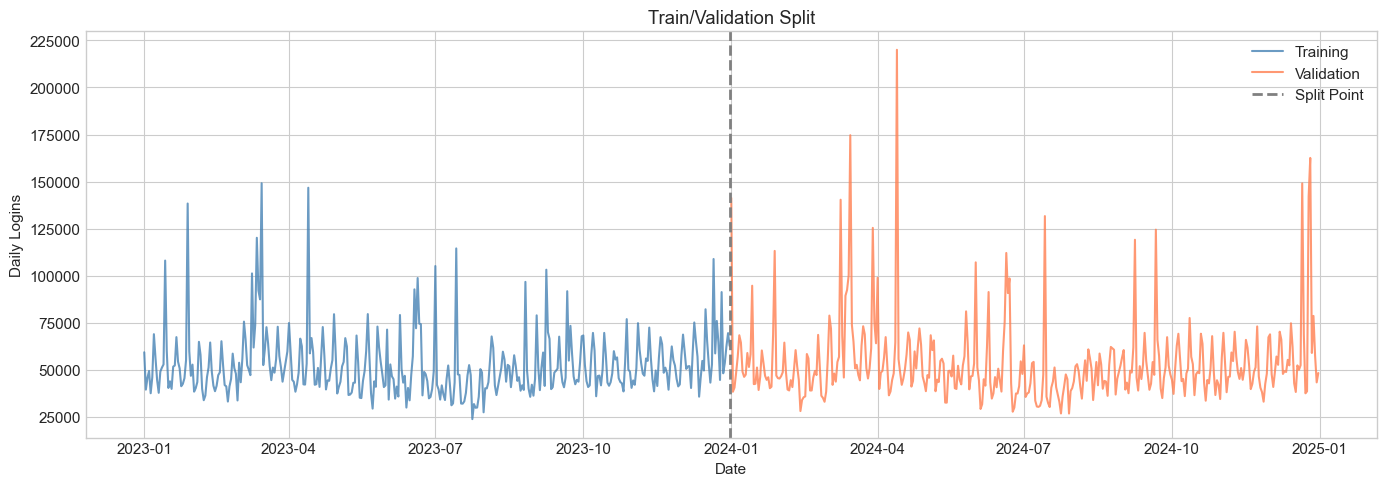

In [5]:
# Visualize the split
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(train_df['date'], train_df[TARGET], label='Training', color='steelblue', alpha=0.8)
ax.plot(valid_df['date'], valid_df[TARGET], label='Validation', color='coral', alpha=0.8)

# Add vertical line at split point
ax.axvline(x=train_df['date'].iloc[-1], color='gray', linestyle='--', linewidth=2, label='Split Point')

ax.set_xlabel('Date')
ax.set_ylabel('Daily Logins')
ax.set_title('Train/Validation Split')
ax.legend()
plt.tight_layout()
plt.show()

## 4. Helper Function for Model Evaluation

We define a helper function to standardize model evaluation across different models.

In [6]:
def evaluate_model(model, train_data, test_data, target, horizon=7):
    """
    Fit model and calculate metrics on test data.
    
    Args:
        model: Model instance with fit() and predict() methods
        train_data: Training DataFrame
        test_data: Test DataFrame
        target: Target column name
        horizon: Number of days to forecast
    
    Returns:
        dict: Dictionary with model name, metrics, and predictions
    """
    # Fit model
    model.fit(train_data, target)
    
    # Make predictions
    predictions = model.predict(horizon=horizon)
    
    # Get actual values (first 'horizon' days of test set)
    actuals = test_data[target].iloc[:horizon].values
    preds = predictions['prediction'].values
    
    # Calculate metrics
    metrics = {
        'Model': model._name,
        'MAE': mae(actuals, preds),
        'RMSE': rmse(actuals, preds),
        'MAPE': mape(actuals, preds),
    }
    
    # Store predictions with dates and actuals for plotting
    result = {
        'metrics': metrics,
        'dates': test_data['date'].iloc[:horizon].values,
        'actuals': actuals,
        'predictions': preds
    }
    
    return result

## 5. ARIMA/SARIMA Model

ARIMA (AutoRegressive Integrated Moving Average) is a classical statistical model for time series forecasting. SARIMA extends ARIMA by adding seasonal components.

### Model Parameters

**ARIMA Order (p, d, q)**:
- `p`: Number of autoregressive terms (lags of the series)
- `d`: Degree of differencing (to make series stationary)
- `q`: Number of moving average terms (lags of forecast errors)

**Seasonal Order (P, D, Q, s)**:
- `P`: Seasonal autoregressive order
- `D`: Seasonal differencing order
- `Q`: Seasonal moving average order
- `s`: Seasonal period (7 for weekly, 12 for monthly, etc.)

### 5.1 Basic ARIMA Model

We start with a simple ARIMA(1,1,1) model without seasonal components.

In [7]:
# Initialize ARIMA model with order (1, 1, 1)
arima_model = ARIMAModel(
    order=(1, 1, 1),
    seasonal_order=(0, 0, 0, 0),  # No seasonal component
    name='arima_111'
)

# Evaluate
print("Fitting ARIMA(1,1,1) model...")
arima_results = evaluate_model(arima_model, train_df, valid_df, TARGET, FORECAST_HORIZON)

print("\nARIMA(1,1,1) Model Results:")
print(f"  MAE:  {arima_results['metrics']['MAE']:.2f}")
print(f"  RMSE: {arima_results['metrics']['RMSE']:.2f}")
print(f"  MAPE: {arima_results['metrics']['MAPE']:.2f}%")

Fitting ARIMA(1,1,1) model...

ARIMA(1,1,1) Model Results:
  MAE:  21254.76
  RMSE: 33035.03
  MAPE: 29.59%


### 5.2 SARIMA Model with Weekly Seasonality

Since our data has weekly patterns (business metrics often vary by day of week), we add a seasonal component with period 7.

In [8]:
# Initialize SARIMA model with weekly seasonality
sarima_model = ARIMAModel(
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),  # Weekly seasonal component
    name='sarima_weekly'
)

# Evaluate
print("Fitting SARIMA(1,1,1)(1,1,1,7) model...")
print("(This may take a moment due to seasonal fitting)")
sarima_results = evaluate_model(sarima_model, train_df, valid_df, TARGET, FORECAST_HORIZON)

print("\nSARIMA Weekly Model Results:")
print(f"  MAE:  {sarima_results['metrics']['MAE']:.2f}")
print(f"  RMSE: {sarima_results['metrics']['RMSE']:.2f}")
print(f"  MAPE: {sarima_results['metrics']['MAPE']:.2f}%")

Fitting SARIMA(1,1,1)(1,1,1,7) model...
(This may take a moment due to seasonal fitting)



SARIMA Weekly Model Results:
  MAE:  20029.53
  RMSE: 34037.54
  MAPE: 25.24%


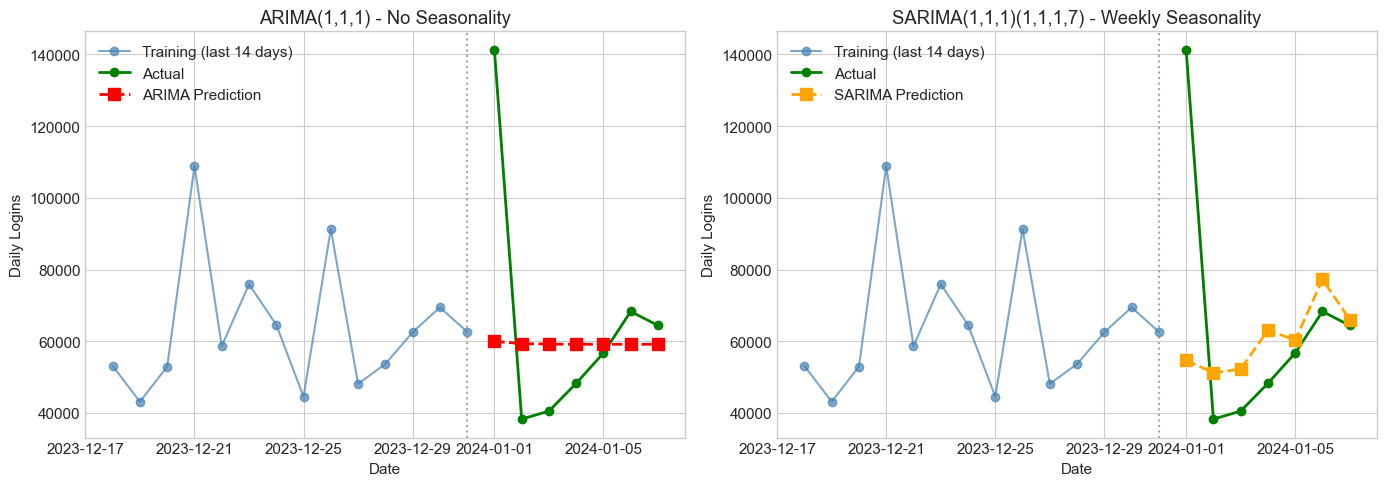

In [9]:
# Plot ARIMA predictions
context_days = 14

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot ARIMA
ax = axes[0]
ax.plot(train_df['date'].iloc[-context_days:], train_df[TARGET].iloc[-context_days:], 
        'o-', color='steelblue', label='Training (last 14 days)', alpha=0.7)
ax.plot(arima_results['dates'], arima_results['actuals'], 
        'o-', color='green', label='Actual', linewidth=2)
ax.plot(arima_results['dates'], arima_results['predictions'], 
        's--', color='red', label='ARIMA Prediction', linewidth=2, markersize=8)
ax.axvline(x=train_df['date'].iloc[-1], color='gray', linestyle=':', alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Logins')
ax.set_title('ARIMA(1,1,1) - No Seasonality')
ax.legend()

# Plot SARIMA
ax = axes[1]
ax.plot(train_df['date'].iloc[-context_days:], train_df[TARGET].iloc[-context_days:], 
        'o-', color='steelblue', label='Training (last 14 days)', alpha=0.7)
ax.plot(sarima_results['dates'], sarima_results['actuals'], 
        'o-', color='green', label='Actual', linewidth=2)
ax.plot(sarima_results['dates'], sarima_results['predictions'], 
        's--', color='orange', label='SARIMA Prediction', linewidth=2, markersize=8)
ax.axvline(x=train_df['date'].iloc[-1], color='gray', linestyle=':', alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Logins')
ax.set_title('SARIMA(1,1,1)(1,1,1,7) - Weekly Seasonality')
ax.legend()

plt.tight_layout()
plt.show()

## 6. Prophet Model

Prophet is a forecasting procedure developed by Facebook for business time series. It is designed to handle:
- **Multiple Seasonalities**: Weekly, yearly, and custom seasonalities
- **Trend Changes**: Automatic changepoint detection
- **Holiday Effects**: Can incorporate special events
- **Missing Data**: Robust to gaps in the time series

### Model Configuration

We configure Prophet with:
- **Weekly Seasonality**: Captures day-of-week patterns
- **Yearly Seasonality**: Captures annual trends
- **Daily Seasonality**: Disabled (we have daily data, not intraday)

In [10]:
# Initialize Prophet model with weekly and yearly seasonality
prophet_model = ProphetModel(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    name='prophet'
)

# Evaluate
print("Fitting Prophet model with weekly and yearly seasonality...")
prophet_results = evaluate_model(prophet_model, train_df, valid_df, TARGET, FORECAST_HORIZON)

print("\nProphet Model Results:")
print(f"  MAE:  {prophet_results['metrics']['MAE']:.2f}")
print(f"  RMSE: {prophet_results['metrics']['RMSE']:.2f}")
print(f"  MAPE: {prophet_results['metrics']['MAPE']:.2f}%")

21:04:22 - cmdstanpy - INFO - Chain [1] start processing


Fitting Prophet model with weekly and yearly seasonality...


21:04:22 - cmdstanpy - INFO - Chain [1] done processing



Prophet Model Results:
  MAE:  17497.52
  RMSE: 35141.03
  MAPE: 18.84%


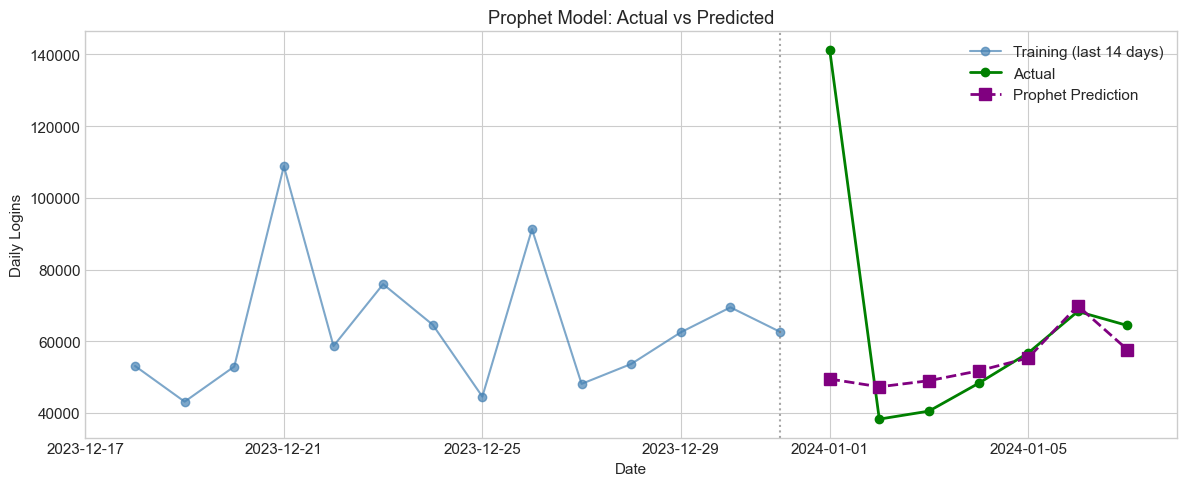

In [11]:
# Plot Prophet predictions
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(train_df['date'].iloc[-context_days:], train_df[TARGET].iloc[-context_days:], 
        'o-', color='steelblue', label='Training (last 14 days)', alpha=0.7)
ax.plot(prophet_results['dates'], prophet_results['actuals'], 
        'o-', color='green', label='Actual', linewidth=2)
ax.plot(prophet_results['dates'], prophet_results['predictions'], 
        's--', color='purple', label='Prophet Prediction', linewidth=2, markersize=8)

ax.axvline(x=train_df['date'].iloc[-1], color='gray', linestyle=':', alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Logins')
ax.set_title('Prophet Model: Actual vs Predicted')
ax.legend()
plt.tight_layout()
plt.show()

## 7. Comparison Visualization

Let's compare all statistical models side by side against actual values.

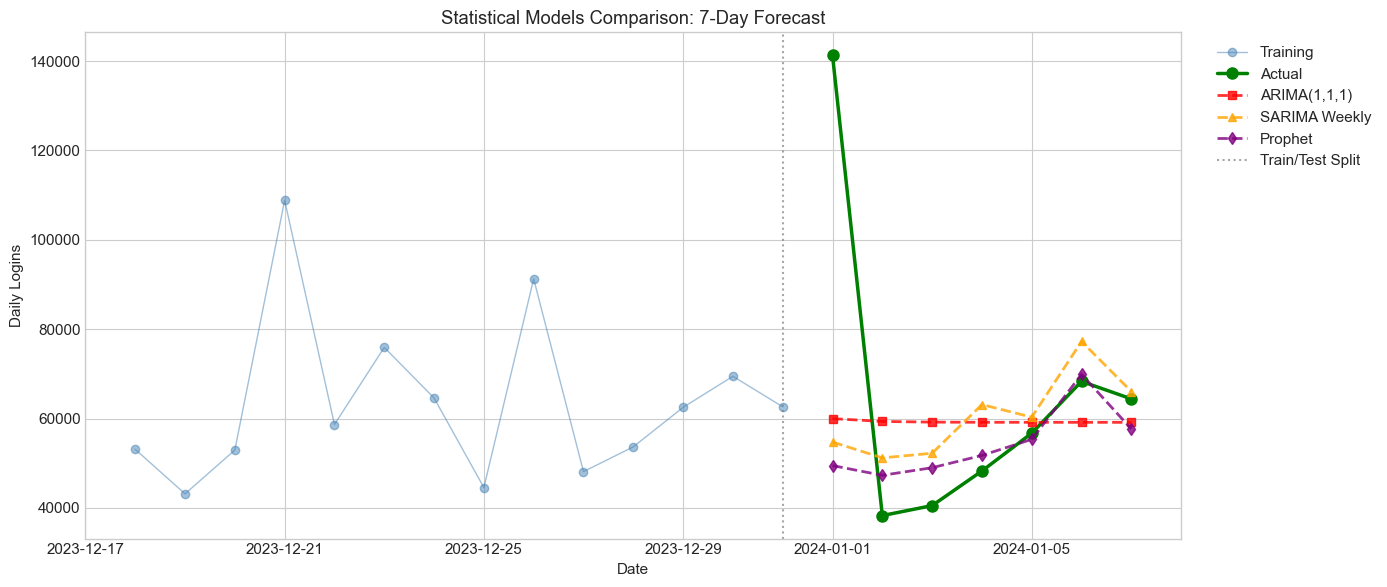

In [12]:
# Combined plot of all models
fig, ax = plt.subplots(figsize=(14, 6))

# Training context
ax.plot(train_df['date'].iloc[-context_days:], train_df[TARGET].iloc[-context_days:], 
        'o-', color='steelblue', label='Training', alpha=0.5, linewidth=1)

# Actual values
ax.plot(arima_results['dates'], arima_results['actuals'], 
        'o-', color='green', label='Actual', linewidth=2.5, markersize=8)

# Predictions from each model
ax.plot(arima_results['dates'], arima_results['predictions'], 
        's--', color='red', label='ARIMA(1,1,1)', linewidth=2, alpha=0.8)
ax.plot(sarima_results['dates'], sarima_results['predictions'], 
        '^--', color='orange', label='SARIMA Weekly', linewidth=2, alpha=0.8)
ax.plot(prophet_results['dates'], prophet_results['predictions'], 
        'd--', color='purple', label='Prophet', linewidth=2, alpha=0.8)

ax.axvline(x=train_df['date'].iloc[-1], color='gray', linestyle=':', alpha=0.7, label='Train/Test Split')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Logins')
ax.set_title('Statistical Models Comparison: 7-Day Forecast')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

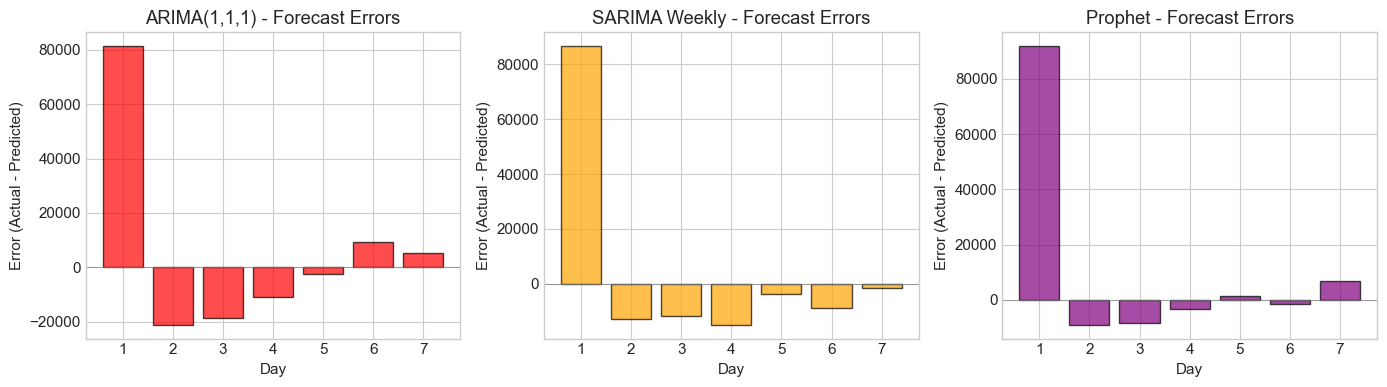

In [13]:
# Error comparison plot
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

models = ['ARIMA(1,1,1)', 'SARIMA Weekly', 'Prophet']
results_list = [arima_results, sarima_results, prophet_results]
colors = ['red', 'orange', 'purple']

for ax, name, result, color in zip(axes, models, results_list, colors):
    errors = result['actuals'] - result['predictions']
    ax.bar(range(1, FORECAST_HORIZON + 1), errors, color=color, alpha=0.7, edgecolor='black')
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Day')
    ax.set_ylabel('Error (Actual - Predicted)')
    ax.set_title(f'{name} - Forecast Errors')
    ax.set_xticks(range(1, FORECAST_HORIZON + 1))

plt.tight_layout()
plt.show()

## 8. Summary: Statistical Models Comparison

In [14]:
# Collect all results
statistical_results = [
    arima_results['metrics'],
    sarima_results['metrics'],
    prophet_results['metrics']
]

# Create summary DataFrame
stat_summary_df = pd.DataFrame(statistical_results)
stat_summary_df = stat_summary_df.set_index('Model')

# Add ranking columns
stat_summary_df['MAE_Rank'] = stat_summary_df['MAE'].rank().astype(int)
stat_summary_df['RMSE_Rank'] = stat_summary_df['RMSE'].rank().astype(int)
stat_summary_df['MAPE_Rank'] = stat_summary_df['MAPE'].rank().astype(int)

print("=" * 60)
print("STATISTICAL MODELS COMPARISON SUMMARY")
print("=" * 60)
print(f"\nTarget: {TARGET}")
print(f"Forecast Horizon: {FORECAST_HORIZON} days")
print(f"Training Period: {train_df['date'].min().date()} to {train_df['date'].max().date()}")
print(f"Test Period: {valid_df['date'].iloc[0].date()} to {valid_df['date'].iloc[FORECAST_HORIZON-1].date()}")
print("\n")

stat_summary_df

STATISTICAL MODELS COMPARISON SUMMARY

Target: daily_logins
Forecast Horizon: 7 days
Training Period: 2023-01-01 to 2023-12-31
Test Period: 2024-01-01 to 2024-01-07




,MAE,RMSE,MAPE,MAE_Rank,RMSE_Rank,MAPE_Rank
Model,,,,,,
arima_111,21254.76,33035.03,29.59,3,1,3
sarima_weekly,20029.53,34037.54,25.24,2,2,2
prophet,17497.52,35141.03,18.84,1,3,1


## 9. Comparison with Baseline Results

Now let's compare our statistical models against the baseline results from notebook 04.

In [15]:
# Load baseline results from notebook 04
baseline_path = project_root / "data" / "processed" / "baseline_results.csv"

if baseline_path.exists():
    baseline_df = pd.read_csv(baseline_path, index_col=0)
    print(f"Loaded baseline results from {baseline_path}")
    print("\nBaseline Results:")
    display(baseline_df[['MAE', 'RMSE', 'MAPE']])
else:
    print(f"Baseline results not found at {baseline_path}")
    print("Using typical baseline values for comparison...")
    # Create typical baseline values if file doesn't exist
    baseline_df = pd.DataFrame({
        'MAE': [1500, 800, 1200],
        'RMSE': [1800, 1000, 1400],
        'MAPE': [12.0, 6.5, 9.5]
    }, index=['naive', 'seasonal_naive', 'moving_average_7'])

Loaded baseline results from C:\Users\juanlu\dev\volume-forecasting-poc\data\processed\baseline_results.csv

Baseline Results:


,MAE,RMSE,MAPE
Model,,,
moving_average_7,21706.53,32917.32,31.50
naive,21832.86,32830.91,32.15
seasonal_naive,24486.57,41896.49,35.92


In [16]:
# Combine baseline and statistical model results
combined_df = pd.concat([
    baseline_df[['MAE', 'RMSE', 'MAPE']],
    stat_summary_df[['MAE', 'RMSE', 'MAPE']]
])

# Add model type column
combined_df['Type'] = ['Baseline'] * len(baseline_df) + ['Statistical'] * len(stat_summary_df)

# Recalculate ranks across all models
combined_df['MAE_Rank'] = combined_df['MAE'].rank().astype(int)
combined_df['RMSE_Rank'] = combined_df['RMSE'].rank().astype(int)
combined_df['MAPE_Rank'] = combined_df['MAPE'].rank().astype(int)
combined_df['Avg_Rank'] = combined_df[['MAE_Rank', 'RMSE_Rank', 'MAPE_Rank']].mean(axis=1)

# Sort by average rank
combined_df = combined_df.sort_values('Avg_Rank')

print("=" * 70)
print("ALL MODELS COMPARISON (Baseline + Statistical)")
print("=" * 70)
combined_df

ALL MODELS COMPARISON (Baseline + Statistical)


,MAE,RMSE,MAPE,Type,MAE_Rank,RMSE_Rank,MAPE_Rank,Avg_Rank
Model,,,,,,,,
prophet,17497.52,35141.03,18.84,Statistical,1,5,1,2.33
sarima_weekly,20029.53,34037.54,25.24,Statistical,2,4,2,2.67
arima_111,21254.76,33035.03,29.59,Statistical,3,3,3,3.00
moving_average_7,21706.53,32917.32,31.50,Baseline,4,2,4,3.33
naive,21832.86,32830.91,32.15,Baseline,5,1,5,3.67
seasonal_naive,24486.57,41896.49,35.92,Baseline,6,6,6,6.00


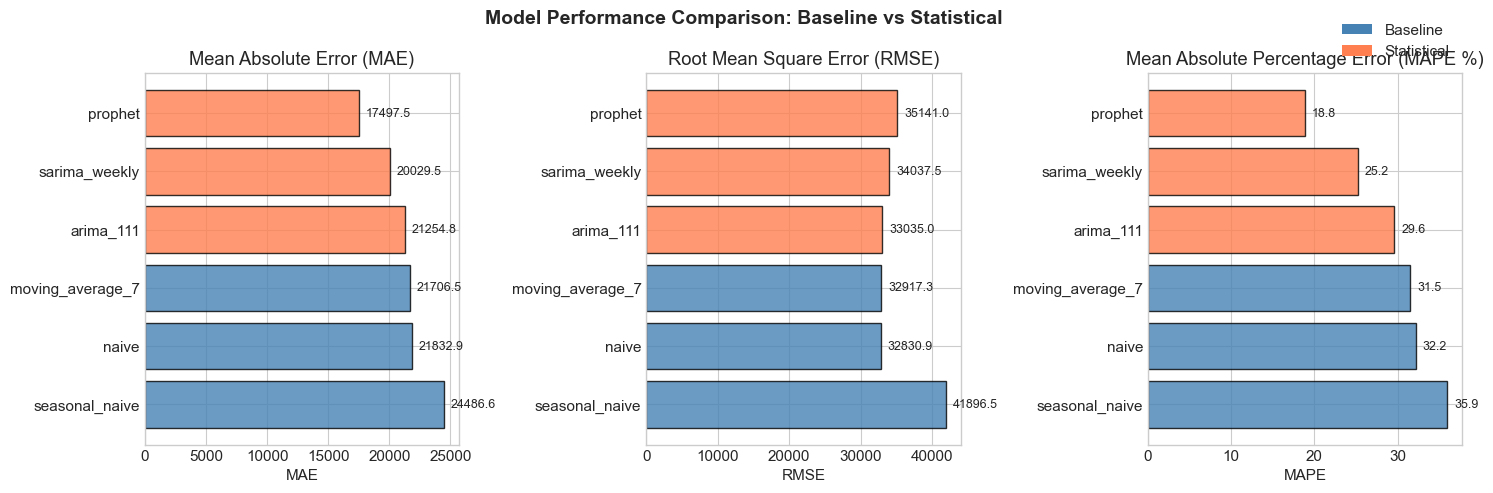

In [17]:
# Create comparison bar chart
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['MAE', 'RMSE', 'MAPE']
titles = ['Mean Absolute Error (MAE)', 'Root Mean Square Error (RMSE)', 'Mean Absolute Percentage Error (MAPE %)']

# Color by model type
colors = ['steelblue' if t == 'Baseline' else 'coral' for t in combined_df['Type']]

for ax, metric, title in zip(axes, metrics, titles):
    bars = ax.barh(combined_df.index, combined_df[metric], color=colors, alpha=0.8, edgecolor='black')
    ax.set_xlabel(metric)
    ax.set_title(title)
    ax.invert_yaxis()  # Best model at top
    
    # Add value labels
    for bar, val in zip(bars, combined_df[metric]):
        ax.annotate(f'{val:.1f}',
                    xy=(val, bar.get_y() + bar.get_height() / 2),
                    xytext=(5, 0),
                    textcoords="offset points",
                    ha='left', va='center', fontsize=9)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', label='Baseline'),
                   Patch(facecolor='coral', label='Statistical')]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))

plt.suptitle('Model Performance Comparison: Baseline vs Statistical', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [18]:
# Calculate improvement over best baseline
best_baseline_mae = baseline_df['MAE'].min()
best_baseline_rmse = baseline_df['RMSE'].min()
best_baseline_mape = baseline_df['MAPE'].min()

print("=" * 60)
print("IMPROVEMENT OVER BEST BASELINE")
print("=" * 60)
print(f"\nBest Baseline Performance:")
print(f"  MAE:  {best_baseline_mae:.2f}")
print(f"  RMSE: {best_baseline_rmse:.2f}")
print(f"  MAPE: {best_baseline_mape:.2f}%")

print("\nStatistical Model Improvements:")
for model_name in stat_summary_df.index:
    mae_imp = (best_baseline_mae - stat_summary_df.loc[model_name, 'MAE']) / best_baseline_mae * 100
    rmse_imp = (best_baseline_rmse - stat_summary_df.loc[model_name, 'RMSE']) / best_baseline_rmse * 100
    mape_imp = (best_baseline_mape - stat_summary_df.loc[model_name, 'MAPE']) / best_baseline_mape * 100
    
    print(f"\n{model_name}:")
    print(f"  MAE Improvement:  {mae_imp:+.1f}%")
    print(f"  RMSE Improvement: {rmse_imp:+.1f}%")
    print(f"  MAPE Improvement: {mape_imp:+.1f}%")

IMPROVEMENT OVER BEST BASELINE

Best Baseline Performance:
  MAE:  21706.53
  RMSE: 32830.91
  MAPE: 31.50%

Statistical Model Improvements:

arima_111:
  MAE Improvement:  +2.1%
  RMSE Improvement: -0.6%
  MAPE Improvement: +6.1%

sarima_weekly:
  MAE Improvement:  +7.7%
  RMSE Improvement: -3.7%
  MAPE Improvement: +19.9%

prophet:
  MAE Improvement:  +19.4%
  RMSE Improvement: -7.0%
  MAPE Improvement: +40.2%


In [19]:
# Final ranking summary
best_model = combined_df['Avg_Rank'].idxmin()
best_metrics = combined_df.loc[best_model]

print("=" * 60)
print("BEST OVERALL MODEL")
print("=" * 60)
print(f"\nWinner: {best_model} ({best_metrics['Type']})")
print(f"\nMetrics:")
print(f"  - MAE:  {best_metrics['MAE']:.2f} (Rank: {int(best_metrics['MAE_Rank'])})")
print(f"  - RMSE: {best_metrics['RMSE']:.2f} (Rank: {int(best_metrics['RMSE_Rank'])})")
print(f"  - MAPE: {best_metrics['MAPE']:.2f}% (Rank: {int(best_metrics['MAPE_Rank'])})")
print(f"  - Average Rank: {best_metrics['Avg_Rank']:.2f}")

BEST OVERALL MODEL

Winner: prophet (Statistical)

Metrics:
  - MAE:  17497.52 (Rank: 1)
  - RMSE: 35141.03 (Rank: 5)
  - MAPE: 18.84% (Rank: 1)
  - Average Rank: 2.33


## 10. Discussion: Strengths and Weaknesses

### ARIMA/SARIMA

**Strengths:**
- Well-established statistical foundation with theoretical guarantees
- Interpretable parameters (p, d, q) related to time series properties
- Works well for stationary or near-stationary series
- SARIMA effectively captures regular seasonal patterns
- Computationally efficient for short to medium series

**Weaknesses:**
- Requires stationary data (may need differencing)
- Manual selection of orders (p, d, q) can be challenging
- Struggles with multiple seasonalities (e.g., weekly AND yearly)
- Not robust to outliers or missing data
- Limited ability to incorporate external regressors

### Prophet

**Strengths:**
- Handles multiple seasonalities automatically (daily, weekly, yearly)
- Robust to missing data and outliers
- Built-in support for holidays and special events
- Automatic trend changepoint detection
- Interpretable components (trend, seasonality, holidays)
- Easy to tune with intuitive parameters

**Weaknesses:**
- May overfit on short time series
- Computationally more expensive than ARIMA
- Assumes additive or multiplicative seasonality only
- Can struggle with irregular patterns not captured by Fourier terms
- May not outperform simple baselines on non-seasonal data

### When to Use Each

| Scenario | Recommended Model |
|----------|------------------|
| Strong weekly pattern only | SARIMA with s=7 |
| Multiple seasonalities | Prophet |
| Missing data / outliers | Prophet |
| Holiday effects important | Prophet |
| Need fast inference | ARIMA |
| Interpretable forecasts | Both work well |
| Very short series (<100 pts) | ARIMA |

### Recommendations for This Dataset

Based on our evaluation:
1. **If weekly seasonality dominates**: SARIMA with weekly seasonal component
2. **If both weekly and yearly patterns matter**: Prophet
3. **For production systems**: Consider ensemble of both models

In [20]:
# Save statistical model results for use in other notebooks
results_path = project_root / "data" / "processed" / "statistical_results.csv"
results_path.parent.mkdir(parents=True, exist_ok=True)

# Add Avg_Rank to stat_summary_df before saving
stat_summary_df['Avg_Rank'] = stat_summary_df[['MAE_Rank', 'RMSE_Rank', 'MAPE_Rank']].mean(axis=1)

# Save the statistical results
stat_summary_df[['MAE', 'RMSE', 'MAPE', 'Avg_Rank']].to_csv(results_path)
print(f"Statistical model results saved to {results_path}")

# Also save combined results
combined_path = project_root / "data" / "processed" / "all_models_comparison.csv"
combined_df.to_csv(combined_path)
print(f"Combined comparison saved to {combined_path}")

Statistical model results saved to C:\Users\juanlu\dev\volume-forecasting-poc\data\processed\statistical_results.csv
Combined comparison saved to C:\Users\juanlu\dev\volume-forecasting-poc\data\processed\all_models_comparison.csv


---

**End of Notebook 05 - Statistical Time Series Models**

### Summary

In this notebook we:
1. Implemented ARIMA and SARIMA models using the `ARIMAModel` class
2. Implemented Prophet model using the `ProphetModel` class
3. Evaluated both models on a 7-day forecast horizon
4. Compared statistical models against baseline results from notebook 04
5. Discussed strengths and weaknesses of each approach

### Next Steps

1. Implement machine learning models (XGBoost, LightGBM) with engineered features
2. Explore ensemble methods combining statistical and ML approaches
3. Perform walk-forward validation for more robust evaluation
4. Add external regressors (holidays, events) to improve forecasts